<a href="https://colab.research.google.com/github/SourLemon23/Eye-Net/blob/main/Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

! pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa

import tensorflow.keras.backend as K

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay

import numpy as np
import matplotlib.pyplot as plt
import cv2

! pip install -U efficientnet
from efficientnet.tfkeras import EfficientNetB4

import pandas as pd
import os

Using TensorFlow Version: 2.5.0
Requirement already up-to-date: efficientnet in /usr/local/lib/python3.7/dist-packages (1.1.1)


In [ ]:
# Authorize access to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Tensorboard logs - Justin's path
logs = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/TB_logs'

In [ ]:
# Folder to save all models - specify your model name at the end of filepath
model_filepath = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/EfficientNet-B4'

In [ ]:
# Justin
dataset_dir = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/cropped_APTOS_dataset'
labels = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/v2APTOSBinaryData.csv'

In [ ]:
CLASSES = ['0 - No DR', '1 - DR']

CHANNELS = 3
COLOR_MODE = 'rgb'

IMG_WIDTH, IMG_HEIGHT = 250, 250
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

LEARNING_RATE = 0.001 # default for Adam
MIN_DELTA = 1e-5
PATIENCE = 4
BATCH_SIZE = 32
EPOCHS = 5
# EPOCHS = 1
VALIDATION_SPLIT = 0.15

METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall'),
           CohenKappa(num_classes=2)]

font_settings = {'family': 'DejaVu Sans',
                  'color' : 'red',
                  'weight': 'heavy',
                  'size'  :  11}

In [ ]:
train_data = pd.read_csv(labels, dtype = str)
Y = train_data['diagnosis']

In [ ]:
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['Presence of DR','# Samples']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'Presence of DR', y='# Samples', data = df_group, palette = "Blues_d")
    plt.title('Class Distribution')
    plt.show()

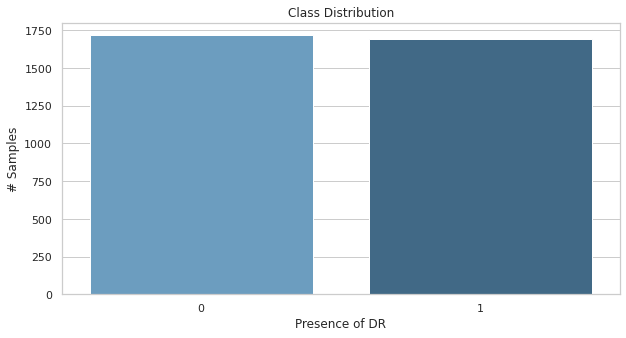

In [ ]:
plot_classes(train_data)

In [ ]:
# insert t-SNE/PCA code here

In [ ]:
data_gen = ImageDataGenerator(validation_split=VALIDATION_SPLIT,
                              featurewise_center=True,
                              featurewise_std_normalization=True,
                              rescale=1./255,              # Simplify pixel values to be 0-1
                              horizontal_flip=True,        # Randomly flip images horizontally
                              zoom_range=0.1,              # Randomly zoom
                              shear_range=0.05,            # Shear angle in counter-clockwise direction
                              rotation_range=5,            # Randomly rotate
                              width_shift_range=0.03,      # Randomly shift the image left/right
                              height_shift_range=0.03,     # Randomly shift the image up/down
                              fill_mode='constant',        # Filling mode for points outside boundaries
                              cval=60,                     # Value used for points outside the boundaries
                              brightness_range=(0.9, 1.1)) # Randomly adjust the brightness
                            #  preprocessing_function for filters (if have time)

In [ ]:
training_generator = data_gen.flow_from_dataframe(train_data, directory = dataset_dir,
                                                    subset = "training",
                                                    x_col = "id_code", y_col = "diagnosis",
                                                    color_mode=COLOR_MODE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode='binary',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    validate_filenames=True)

validation_generator = data_gen.flow_from_dataframe(train_data, directory = dataset_dir,
                                                    subset = "validation",
                                                    x_col = "id_code", y_col = "diagnosis",
                                                    color_mode=COLOR_MODE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode='binary',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    validate_filenames=True)

Found 2900 validated image filenames belonging to 2 classes.
Found 511 validated image filenames belonging to 2 classes.


In [ ]:
def visualize_augmentations(data_generator):
    batch = data_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]

    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(24, 14), constrained_layout=True)
    batch_length = len(image_batch)

    for i, image in enumerate(image_batch):
        if int(batch_labels[i]) == 0:
            title = 'no_DR'
            font_settings.update({'color': 'blue'})
        else:
            title = 'DR'
            font_settings.update({'color': 'red'})

        if i < (1 / 4) * batch_length:
            axs[0, i].imshow(image_batch[i])
            axs[0, i].set_title(title, fontdict=font_settings)
            axs[0, i].axis('off')
        elif i < (2 / 4) * batch_length:
            axs[1, i - 8].imshow(image_batch[i])
            axs[1, i - 8].set_title(title, fontdict=font_settings)
            axs[1, i - 8].axis('off')
        elif i < (3 / 4) * batch_length:
            axs[2, i - 16].imshow(image_batch[i])
            axs[2, i - 16].set_title(title, fontdict=font_settings)
            axs[2, i - 16].axis('off')
        else:
            axs[3, i - 24].imshow(image_batch[i])
            axs[3, i - 24].set_title(title, fontdict=font_settings)     
            axs[3, i - 24].axis('off')   

    plt.show()

In [ ]:
# # run this cell once in a while to make sure the images are correct
# print('Training Batch:')
# visualize_augmentations(training_generator)

# print('\nValidation Batch:')
# visualize_augmentations(validation_generator)

In [ ]:
def create_model(print_summary=False):
    # Instantiate a base model with pre-trained weights
    base_model = EfficientNetB4(weights='imagenet',
                                include_top=False,
                                input_shape=INPUT_SHAPE)
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output

    # Add new layers to the end of the base model
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Add a final dense layer with a single neuron (logistic regression)
    predictions = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.inputs, outputs=predictions)

    if print_summary:
        model.summary()

    return model

In [ ]:
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=LEARNING_RATE),
                  metrics=METRICS)

In [ ]:
def fit_model(model):
    early_stopping_cb = EarlyStopping(monitor='val_accuracy',
                                      min_delta=MIN_DELTA,
                                      patience=PATIENCE,
                                      mode='max',
                                      restore_best_weights=True)
    
    # Make sure to change this model name
    log_dir = logs + r'/EfficientNet-B4'
    tensorboard_cb = TensorBoard(log_dir=log_dir,
                                 histogram_freq=1)
    
    callbacks = [early_stopping_cb, tensorboard_cb]
    
    history = model.fit(training_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=(training_generator.n/BATCH_SIZE),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/BATCH_SIZE),
                        callbacks=callbacks)
    
    return history

In [ ]:
def evaluate_model(history):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 4), constrained_layout=True)

    f1_scores = []
    # calculate f1-score from precision and recall
    for i in range(len(history.history['val_recall'])):
        if history.history['val_precision'][i] != 0 and history.history['val_recall'][i] != 0:
            f1_scores.append((2 * history.history['val_precision'][i] * history.history['val_recall'][i]) / (history.history['val_precision'][i] + history.history['val_recall'][i]))

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall', 'cohen_kappa']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])
        
        if metric is not 'loss':
            non_zeros = [num for num in history.history['val_' + metric] if num != 0]
            avg = "{:.4f}".format(np.mean(non_zeros))
            std = "{:.4f}".format(np.std(non_zeros))
            se = "{:.4f}".format(float(std) / (validation_generator.n) ** 0.5)
            print(metric + ': {} ± {}'.format(avg, se))
    
    # print f1-score
    f1_score = "{:.4f}".format(f1_scores[-1])
    avg = "{:.4f}".format(np.mean(f1_scores))
    std = "{:.4f}".format(np.std(f1_scores))
    se = "{:.4f}".format(float(std) / (validation_generator.n) ** 0.5)
    print('final f1-score: ' + f1_score)
    print('f1-score' + ': {} ± {}'.format(avg, se))

In [ ]:
model = create_model(print_summary=True)
compile_model(model)

71892992/71892840 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 125, 125, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 125, 125, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 125, 125, 48) 0           stem_bn[0][0]                    
_____________________________

In [ ]:
history = fit_model(model)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
91/90 [==============================] - ETA: -10s - loss: 0.3097 - accuracy: 0.8759 - precision: 0.8775 - recall: 0.8676 - cohen_kappa: 0.7516

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


90/90 [==============================] - 2988s 33s/step - loss: 0.3097 - accuracy: 0.8759 - precision: 0.8775 - recall: 0.8676 - cohen_kappa: 0.7516 - val_loss: 0.1484 - val_accuracy: 0.9609 - val_precision: 0.9603 - val_recall: 0.9673 - val_cohen_kappa: 0.9212
Epoch 2/5
90/90 [==============================] - 2359s 26s/step - loss: 0.2046 - accuracy: 0.9259 - precision: 0.9356 - recall: 0.9113 - cohen_kappa: 0.8516 - val_loss: 0.2133 - val_accuracy: 0.9061 - val_precision: 0.8626 - val_recall: 0.9818 - val_cohen_kappa: 0.8088
Epoch 3/5
90/90 [==============================] - 2325s 26s/step - loss: 0.1925 - accuracy: 0.9238 - precision: 0.9335 - recall: 0.9092 - cohen_kappa: 0.8474 - val_loss: 0.1448 - val_accuracy: 0.9530 - val_precision: 0.9404 - val_recall: 0.9745 - val_cohen_kappa: 0.9052
Epoch 4/5
90/90 [==============================] - 2373s 26s/step - loss: 0.1761 - accuracy: 0.9369 - precision: 0.9415 - recall: 0.9289 - cohen_kappa: 0.8737 - val_loss: 0.1566 - val_accuracy: 

In [ ]:
model.save(model_filepath)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/EfficientNet-B4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/EfficientNet-B4/assets


http://seaborn.pydata.org/tutorial/aesthetics.html

In [ ]:
sns.set_context("paper") # darker gray background on plots
# sns.set_style("whitegrid")
sns.set_theme()

accuracy: 0.9327 ± 0.0010
precision: 0.9344 ± 0.0019
recall: 0.9455 ± 0.0025
cohen_kappa: 0.8644 ± 0.0020
final f1-score: 0.9051
f1-score: 0.9376 ± 0.0010


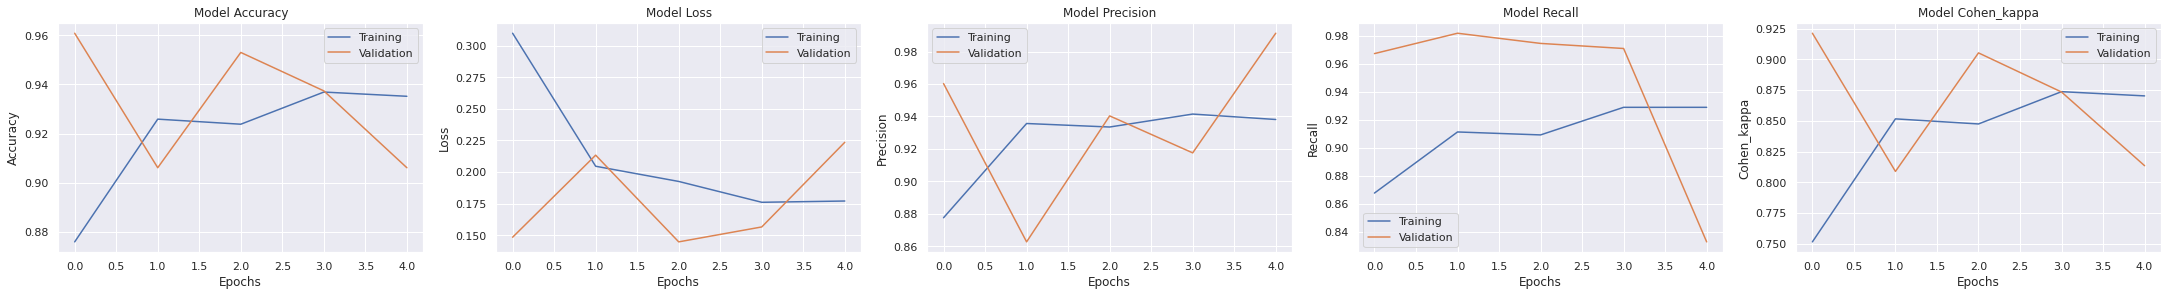

In [ ]:
evaluate_model(history)

In [ ]:
# def plot_confusion_matrix(data_generator, predictions):
#     cm = confusion_matrix(y_true=data_generator.labels, y_pred=predictions)
#     cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    
#     cm_display.plot(include_values=True,
#                     cmap='Blues',
#                     xticks_rotation=45,
#                     values_format='.5g')
    
#     plt.title('Confusion Matrix', fontdict = {'family': 'DejaVu Sans',
#                                               'color' : 'black',
#                                               'weight': 'heavy',
#                                               'size'  :  12})
#     plt.tick_params(axis=u'both', which=u'both',length=0)
#     plt.grid(b=None)

#     plt.show()

In [ ]:
# # not much a difference from ^, but might just look better and maybe easier to work with
# # note that it has a weird font and style when plotting graphs, RUN THIS LAST..
# def plot_heatmap_confusion_matrix(data_generator, predictions):
#     cf = confusion_matrix(y_true=data_generator.labels, y_pred=predictions)
    
#     df_cm = pd.DataFrame(cf, range(len(CLASSES)), range(len(CLASSES)))
#     plt.figure(figsize=(6, 4))
#     sns.set(font_scale=1.0)
#     sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, xticklabels=CLASSES, yticklabels=CLASSES, fmt='g')
#     # sns.heatmap(df_cm, annot=True, cmap='Blues', annot_kws={"size": 16}, xticklabels=CLASSES, yticklabels=CLASSES, fmt='g')

#     plt.xlabel('Predicted Labels', labelpad=20)
#     plt.ylabel('Ground Truth Labels', labelpad=20)
#     plt.title('Confusion Matrix', fontdict = {'family': 'DejaVu Sans',
#                                               'color' : 'black',
#                                               'weight': 'heavy',
#                                               'size'  :  12})
#     plt.show()

In [ ]:
# def plot_precision_recall(data_generator, predictions, ax):
#     precision, recall, thresholds = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions)
#     average_precision = average_precision_score(y_true=data_generator.labels, y_score=predictions)
#     pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name=None)
    
#     pr_display.plot(ax=ax, name='Proposed Model')
    
#     ax.set_title('Precision Recall Curve', fontdict = {'family': 'DejaVu Sans',
#                                                        'color' : 'black',
#                                                        'weight': 'heavy',
#                                                        'size'  :  12})

In [ ]:
# def plot_roc_curve(data_generator, predictions, ax):
#     ns_predictions = [0 for i in range(data_generator.n)]

#     ns_auc = roc_auc_score(y_true=data_generator.labels, y_score=ns_predictions)
#     auc = roc_auc_score(y_true=data_generator.labels, y_score=predictions)

#     ns_fpr, ns_tpr, ns_thresholds = roc_curve(y_true=validation_generator2.labels, y_score=ns_predictions)
#     fpr, tpr, thresholds = roc_curve(y_true=validation_generator2.labels, y_score=predictions)    

#     ax.plot(fpr, tpr, marker='.', label='Proposed Model (AUC = %0.3f)' % auc)
#     ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = %0.3f)' % ns_auc)

#     ax.set_title('ROC Curve', fontdict = {'family': 'DejaVu Sans',
#                                          'color' : 'black',
#                                          'weight': 'heavy',
#                                          'size'  :  12})
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.legend()

In [ ]:
# def print_classification_report(data_generator, predictions):
#     cr = classification_report(y_true=data_generator.labels, y_pred=predictions)
#     print(cr)

In [ ]:
# # we need to load in an unshuffled val gen for evaluation purposes
# validation_generator2 = data_gen.flow_from_dataframe(train_data, directory = dataset_dir,
#                                                     subset = "validation",
#                                                     x_col = "id_code", y_col = "diagnosis",
#                                                     color_mode=COLOR_MODE,
#                                                     target_size=TARGET_SIZE,
#                                                     class_mode='binary',
#                                                     batch_size=BATCH_SIZE,
#                                                     shuffle=False, # has to be false for evaluations to work
#                                                     validate_filenames=True)

In [ ]:
# predictions = model.predict(validation_generator2,
#                             verbose=1)
# rounded_predictions = np.around(predictions.copy()).astype(int)

In [ ]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# plot_roc_curve(validation_generator2, predictions, ax1)
# plot_precision_recall(validation_generator2, predictions, ax2)

In [ ]:
# plot_confusion_matrix(validation_generator2, rounded_predictions)

In [ ]:
# plot_heatmap_confusion_matrix(validation_generator2, rounded_predictions)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html - INCLUDE LABELS PARAM TO GET MICRO_AVG
# print_classification_report(validation_generator2, rounded_predictions)

In [ ]:
# # Don't need since we already calculated this when fitting the model
# ck_score = cohen_kappa_score(rounded_predictions, validation_generator.labels, weights='quadratic')
# print("Cohen Kappa score: %.3f" % ck_score)

---

Everything below is from cross validation, disregard

In [ ]:
# for train_index, val_index in skf.split(np.zeros(1187), Y):
 
#   training_data = train_data.iloc[train_index]
#   validation_data = train_data.iloc[val_index]
  
  
#   training_generator = data_gen.flow_from_dataframe(training_data, directory = dataset_dir,
#                                                     x_col = "Image Name", y_col = "Retinopathy Grade",
#                                                     color_mode=COLOR_MODE,
#                                                     target_size=TARGET_SIZE,
#                                                     class_mode='binary',
#                                                     batch_size=BATCH_SIZE,
#                                                     shuffle=True,
#                                                     validate_filenames=True)

#   validation_generator = data_gen.flow_from_dataframe(validation_data, directory = dataset_dir,
#                                                     x_col = "Image Name", y_col = "Retinopathy Grade",
#                                                     color_mode=COLOR_MODE,
#                                                     target_size=TARGET_SIZE,
#                                                     class_mode='binary',
#                                                     batch_size=BATCH_SIZE,
#                                                     shuffle=True,
#                                                     validate_filenames=True)
  
#   # print(training_generator)
	
 
#   model = create_model(print_summary=True)
#   compile_model(model)
	
# 	# # CREATE CALLBACKS
#   # checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir + get_model_name(fold_var), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#   # callbacks_list = [checkpoint]
# 	# # There can be other callbacks, but just showing one because it involves the model name
# 	# # This saves the best model
# 	# # FIT THE MODEL
  
#   history = fit_model(model)
 
# 	# #PLOT HISTORY
# 	# #		:
# 	# #		:
	
# 	# # LOAD BEST MODEL to evaluate the performance of the model
#   # model.load_weights(save_dir + '/model_' + str(fold_var) + ".h5")
#   # results = model.evaluate(valid_data_generator)
#   # results = dict(zip(model.metrics_names,results))
  
#   # VALIDATION_ACCURACY.append(results['accuracy'])
#   # VALIDATION_LOSS.append(results['loss'])
#   # tf.keras.backend.clear_session()


#   fold_var += 1

In [ ]:
# def get_model_name(k):
#     return 'model_'+str(k)+'.h5'

In [ ]:
# X_train = []

# for img in (train_data['Image Name']):
#     loaded_img = load_img(os.path.join(dataset_dir, img))
#     img_arr = img_to_array(loaded_img)
#     X_train.append(img_arr)
  
# y_train = train_data.drop('Retinopathy Grade', axis=1, inplace=False)

# X_train = np.array(X_train)
# y_train = np.array(y_train.values)

# print(X_train)
# print(y_train)

# sm = SMOTE()
# training_data = sm.fit_resample()

# from PIL import Image
# import glob

# X_train = []
# for img in glob.glob('/content/drive/MyDrive/cropped_messidor_dataset/*.tif'): #assuming gif
#     im=Image.open(img)
#     X_train.append(im)

# y_train = training_data.drop('Retinopathy Grade', axis=1, inplace=False)

# y_train = np.array(y_train.values)
# X_train = np.array(X_train)